# Experiment: MSFT 1-Minute GRU Forecast (Realistic Autoregressive v7)

Key changes for realistic candles:
1. Probabilistic outputs (mu + log_sigma) with sampling
2. Autoregressive recursive generation (feed predictions back)
3. Temperature-controlled noise injection for volatility
4. Volatility matching to recent historical realized vol
5. Strict candle validity enforcement at each step

## Package Installation & Imports

In [1]:
import importlib.util
import subprocess
import sys

required = {
    'alpaca': 'alpaca-py',
    'numpy': 'numpy',
    'pandas': 'pandas',
    'matplotlib': 'matplotlib',
    'pandas_market_calendars': 'pandas-market-calendars',
}
missing = [pkg for mod, pkg in required.items() if importlib.util.find_spec(mod) is None]
if missing:
    print('Installing missing packages:', missing)
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', *missing])
else:
    print('All required third-party packages are already installed.')

All required third-party packages are already installed.


In [2]:
from __future__ import annotations
import copy
import os
import random
import time
from datetime import datetime, timedelta, timezone
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import torch
import torch.nn as nn
from alpaca.data.enums import DataFeed
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib.patches import Patch, Rectangle
from torch.utils.data import DataLoader, Dataset

## Random Seed & Device Setup

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3070


## Configuration

In [4]:
# Data Configuration
SYMBOL = 'MSFT'
LOOKBACK_DAYS = 120
OHLC_COLS = ['Open', 'High', 'Low', 'Close']
RAW_COLS = OHLC_COLS + ['Volume', 'TradeCount', 'VWAP']
BASE_FEATURE_COLS = [
    'rOpen', 'rHigh', 'rLow', 'rClose',
    'logVolChange', 'logTradeCountChange',
    'vwapDelta', 'rangeFrac', 'orderFlowProxy', 'tickPressure',
]
TARGET_COLS = ['rOpen', 'rHigh', 'rLow', 'rClose']
INPUT_EXTRA_COL = 'imputedFracWindow'

HORIZON = 15
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
LOOKBACK_CANDIDATES = [64, 96, 160, 256]
DEFAULT_LOOKBACK = 96
ENABLE_LOOKBACK_SWEEP = True
SKIP_OPEN_BARS_TARGET = 6

In [5]:
# Model Configuration
HIDDEN_SIZE = 256  # Increased for better generation capacity
NUM_LAYERS = 2
DROPOUT = 0.20     # Slightly higher for stochasticity
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 256

In [6]:
# Training Configuration
SWEEP_MAX_EPOCHS = 15
SWEEP_PATIENCE = 5
FINAL_MAX_EPOCHS = 60  # More epochs for convergence
FINAL_PATIENCE = 12
TF_START = 1.0
TF_END = 0.0
TF_DECAY_RATE = 0.95

In [7]:
# Loss Configuration
RANGE_LOSS_WEIGHT = 0.3
VOLATILITY_WEIGHT = 0.5  # Encourage proper volatility
DIR_PENALTY_WEIGHT = 0.1
STEP_LOSS_POWER = 1.5

In [8]:
# Inference Configuration
SAMPLING_TEMPERATURE = 1.5  # >1.0 = more volatile/wild, <1.0 = conservative
VOLATILITY_SCALING = True   # Match recent realized vol
MIN_PREDICTED_VOL = 0.0001  # Minimum volatility to prevent flat lines

In [9]:
# Data Processing Configuration
STANDARDIZE_TARGETS = False
APPLY_CLIPPING = True
CLIP_QUANTILES = (0.001, 0.999)
DIRECTION_EPS = 0.0001
STD_RATIO_TARGET_MIN = 0.3

In [10]:
# Alpaca API Configuration
ALPACA_FEED = os.getenv('ALPACA_FEED', 'iex').strip().lower()
SESSION_TZ = 'America/New_York'
REQUEST_CHUNK_DAYS = 5
MAX_REQUESTS_PER_MINUTE = 120
MAX_RETRIES = 5
MAX_SESSION_FILL_RATIO = 0.15

In [11]:
# Print Configuration Summary
print({
    'symbol': SYMBOL,
    'lookback_days': LOOKBACK_DAYS,
    'horizon': HORIZON,
    'sampling_temperature': SAMPLING_TEMPERATURE,
    'loss_weights': {
        'range': RANGE_LOSS_WEIGHT,
        'volatility': VOLATILITY_WEIGHT,
        'dir_penalty': DIR_PENALTY_WEIGHT,
    },
    'device': str(DEVICE),
})

{'symbol': 'MSFT', 'lookback_days': 120, 'horizon': 15, 'sampling_temperature': 1.5, 'loss_weights': {'range': 0.3, 'volatility': 0.5, 'dir_penalty': 0.1}, 'device': 'cuda'}


## Data Fetching Functions

In [12]:
class RequestPacer:
    def __init__(self, max_calls_per_minute: int):
        if max_calls_per_minute <= 0:
            raise ValueError('max_calls_per_minute must be >0')
        self.min_interval = 60.0 / float(max_calls_per_minute)
        self.last_call_ts = 0.0
        
    def wait(self) -> None:
        now = time.monotonic()
        elapsed = now - self.last_call_ts
        if elapsed < self.min_interval:
            time.sleep(self.min_interval - elapsed)
        self.last_call_ts = time.monotonic()

In [13]:
def _require_alpaca_credentials() -> tuple[str, str]:
    api_key = os.getenv('ALPACA_API_KEY')
    secret_key = os.getenv('ALPACA_SECRET_KEY')
    if not api_key or not secret_key:
        raise RuntimeError('Missing ALPACA_API_KEY / ALPACA_SECRET_KEY.')
    return api_key, secret_key

def _resolve_feed(feed_name: str) -> DataFeed:
    mapping = {'iex': DataFeed.IEX, 'sip': DataFeed.SIP, 'delayed_sip': DataFeed.DELAYED_SIP}
    k = feed_name.strip().lower()
    if k not in mapping:
        raise ValueError(f'Unsupported ALPACA_FEED={feed_name!r}. Use one of: {list(mapping)}')
    return mapping[k]

In [14]:
def fetch_bars_alpaca(symbol: str, lookback_days: int) -> tuple[pd.DataFrame, int]:
    api_key, secret_key = _require_alpaca_credentials()
    client = StockHistoricalDataClient(api_key=api_key, secret_key=secret_key)
    feed = _resolve_feed(ALPACA_FEED)
    pacer = RequestPacer(MAX_REQUESTS_PER_MINUTE)
    
    end_ts = datetime.now(timezone.utc).replace(second=0, microsecond=0)
    if ALPACA_FEED in {'sip', 'delayed_sip'}:
        end_ts = end_ts - timedelta(minutes=20)
    start_ts = end_ts - timedelta(days=lookback_days)
    
    parts = []
    cursor = start_ts
    calls = 0
    
    while cursor < end_ts:
        chunk_end = min(cursor + timedelta(days=REQUEST_CHUNK_DAYS), end_ts)
        chunk = None
        for attempt in range(1, MAX_RETRIES + 1):
            pacer.wait()
            calls += 1
            try:
                req = StockBarsRequest(
                    symbol_or_symbols=[symbol],
                    timeframe=TimeFrame.Minute,
                    start=cursor,
                    end=chunk_end,
                    feed=feed,
                    limit=10000,
                )
                chunk = client.get_stock_bars(req).df
                break
            except Exception as exc:
                msg = str(exc).lower()
                if ('429' in msg or 'rate limit' in msg) and attempt < MAX_RETRIES:
                    backoff = min(2 ** attempt, 30)
                    print(f'Rate-limited; sleeping {backoff}s (attempt {attempt}/{MAX_RETRIES}).')
                    time.sleep(backoff)
                    continue
                if ('subscription' in msg or 'forbidden' in msg) and ALPACA_FEED != 'iex':
                    raise RuntimeError('Feed unavailable for account. Use ALPACA_FEED=iex or upgrade subscription.') from exc
                raise
        if chunk is not None and not chunk.empty:
            d = chunk.reset_index().rename(columns={
                'timestamp': 'Datetime', 'open': 'Open', 'high': 'High',
                'low': 'Low', 'close': 'Close', 'volume': 'Volume',
                'trade_count': 'TradeCount', 'vwap': 'VWAP',
            })
            if 'Volume' not in d.columns:
                d['Volume'] = 0.0
            if 'TradeCount' not in d.columns:
                d['TradeCount'] = 0.0
            if 'VWAP' not in d.columns:
                d['VWAP'] = d['Close']
            
            need = ['Datetime'] + RAW_COLS
            d['Datetime'] = pd.to_datetime(d['Datetime'], utc=True)
            d = d[need].dropna(subset=OHLC_COLS).set_index('Datetime').sort_index()
            parts.append(d)
        cursor = chunk_end
    
    if not parts:
        raise RuntimeError('No bars returned from Alpaca.')
    out = pd.concat(parts, axis=0).sort_index()
    out = out[~out.index.duplicated(keep='last')]
    return out.astype(np.float32), calls

In [15]:
def sessionize_with_calendar(df_utc: pd.DataFrame) -> tuple[pd.DataFrame, dict]:
    if df_utc.empty:
        raise RuntimeError('Input bars are empty.')
    
    idx = pd.DatetimeIndex(df_utc.index)
    if idx.tz is None:
        idx = idx.tz_localize('UTC')
    else:
        idx = idx.tz_convert('UTC')
    
    df_utc = df_utc.copy()
    df_utc.index = idx
    
    cal = mcal.get_calendar('XNYS')
    sched = cal.schedule(
        start_date=(idx.min() - pd.Timedelta(days=2)).date(),
        end_date=(idx.max() + pd.Timedelta(days=2)).date(),
    )
    
    pieces = []
    fill_ratios = []
    
    for sid, (_, row) in enumerate(sched.iterrows()):
        open_ts = pd.Timestamp(row['market_open'])
        close_ts = pd.Timestamp(row['market_close'])
        
        if open_ts.tzinfo is None:
            open_ts = open_ts.tz_localize('UTC')
        else:
            open_ts = open_ts.tz_convert('UTC')
        if close_ts.tzinfo is None:
            close_ts = close_ts.tz_localize('UTC')
        else:
            close_ts = close_ts.tz_convert('UTC')
            
        exp_idx = pd.date_range(open_ts, close_ts, freq='1min', inclusive='left')
        if len(exp_idx) == 0:
            continue
            
        day = df_utc[(df_utc.index >= open_ts) & (df_utc.index < close_ts)]
        day = day.reindex(exp_idx)
        imputed = day[OHLC_COLS].isna().any(axis=1).to_numpy()
        fill_ratio = float(imputed.mean())
        
        if fill_ratio >= 1.0 or fill_ratio > MAX_SESSION_FILL_RATIO:
            continue
            
        day[OHLC_COLS + ['VWAP']] = day[OHLC_COLS + ['VWAP']].ffill().bfill()
        if day['VWAP'].isna().all():
            day['VWAP'] = day['Close']
        else:
            day['VWAP'] = day['VWAP'].fillna(day['Close'])
            
        day['Volume'] = day['Volume'].fillna(0.0)
        day['TradeCount'] = day['TradeCount'].fillna(0.0)
        day['is_imputed'] = imputed.astype(np.int8)
        day['session_id'] = int(sid)
        day['bar_in_session'] = np.arange(len(day), dtype=np.int32)
        day['session_len'] = int(len(day))
        
        if day[RAW_COLS].isna().any().any():
            raise RuntimeError('NaNs remain after per-session fill.')
        pieces.append(day)
        fill_ratios.append(fill_ratio)
    
    if not pieces:
        raise RuntimeError('No sessions kept after calendar filtering.')
        
    out = pd.concat(pieces, axis=0).sort_index()
    out.index = out.index.tz_convert(SESSION_TZ).tz_localize(None)
    out = out.copy()
    
    for c in RAW_COLS:
        out[c] = out[c].astype(np.float32)
    out['is_imputed'] = out['is_imputed'].astype(np.int8)
    out['session_id'] = out['session_id'].astype(np.int32)
    out['bar_in_session'] = out['bar_in_session'].astype(np.int32)
    out['session_len'] = out['session_len'].astype(np.int32)
    
    meta = {
        'calendar_sessions_total': int(len(sched)),
        'kept_sessions': int(len(pieces)),
        'avg_fill_ratio_kept': float(np.mean(fill_ratios)) if fill_ratios else float('nan'),
    }
    return out, meta

## Fetch Data from Alpaca

In [16]:
raw_df_utc, api_calls = fetch_bars_alpaca(SYMBOL, LOOKBACK_DAYS)
price_df, session_meta = sessionize_with_calendar(raw_df_utc)
print(f'Raw rows from Alpaca: {len(raw_df_utc):,}')
print(f'Sessionized rows kept: {len(price_df):,}')
print('Session meta:', session_meta)

min_needed = max(LOOKBACK_CANDIDATES) + HORIZON + 1000
if len(price_df) < min_needed:
    raise RuntimeError(f'Not enough rows after session filtering ({len(price_df)}). Need at least {min_needed}.')

Raw rows from Alpaca: 31,214
Sessionized rows kept: 30,840
Session meta: {'calendar_sessions_total': 85, 'kept_sessions': 80, 'avg_fill_ratio_kept': 0.00951007326007326}


## Feature Engineering Functions

In [17]:
def enforce_candle_validity(ohlc: np.ndarray) -> np.ndarray:
    out = np.asarray(ohlc, dtype=np.float32)
    o, h, l, c = out[:, 0], out[:, 1], out[:, 2], out[:, 3]
    out[:, 1] = np.maximum.reduce([h, o, c])
    out[:, 2] = np.minimum.reduce([l, o, c])
    return out

def returns_to_prices_seq(return_ohlc: np.ndarray, last_close: float) -> np.ndarray:
    seq = []
    prev_close = float(last_close)
    for rO, rH, rL, rC in np.asarray(return_ohlc, dtype=np.float32):
        o = prev_close * np.exp(float(rO))
        h = prev_close * np.exp(float(rH))
        l = prev_close * np.exp(float(rL))
        c = prev_close * np.exp(float(rC))
        cand = enforce_candle_validity(np.array([[o, h, l, c]], dtype=np.float32))[0]
        seq.append(cand)
        prev_close = float(cand[3])
    return np.asarray(seq, dtype=np.float32)

In [18]:
def build_feature_frame(df: pd.DataFrame) -> pd.DataFrame:
    eps = 1e-9
    g = df.groupby('session_id', sort=False)
    prev_close = g['Close'].shift(1)
    prev_close = prev_close.fillna(df['Open'])
    prev_vol = g['Volume'].shift(1).fillna(df['Volume'])
    prev_tc = g['TradeCount'].shift(1).fillna(df['TradeCount'])
    prev_imp = g['is_imputed'].shift(1).fillna(0).astype(bool)
    
    row_imputed = (df['is_imputed'].astype(bool) | prev_imp)
    row_open_skip = (df['bar_in_session'].astype(int) < SKIP_OPEN_BARS_TARGET)
    
    out = pd.DataFrame(index=df.index, dtype=np.float32)
    out['rOpen'] = np.log(df['Open'] / (prev_close + eps))
    out['rHigh'] = np.log(df['High'] / (prev_close + eps))
    out['rLow'] = np.log(df['Low'] / (prev_close + eps))
    out['rClose'] = np.log(df['Close'] / (prev_close + eps))
    out['logVolChange'] = np.log((df['Volume'] + 1.0) / (prev_vol + 1.0))
    out['logTradeCountChange'] = np.log((df['TradeCount'] + 1.0) / (prev_tc + 1.0))
    out['vwapDelta'] = np.log((df['VWAP'] + eps) / (df['Close'] + eps))
    out['rangeFrac'] = np.maximum(out['rHigh'] - out['rLow'], 0) / (np.abs(out['rClose']) + eps)
    
    signed_body = (df['Close'] - df['Open']) / ((df['High'] - df['Low']) + eps)
    out['orderFlowProxy'] = signed_body * np.log1p(df['Volume'])
    out['tickPressure'] = np.sign(df['Close'] - df['Open']) * np.log1p(df['TradeCount'])
    
    out['row_imputed'] = row_imputed.astype(np.int8).to_numpy()
    out['row_open_skip'] = row_open_skip.astype(np.int8).to_numpy()
    out['prev_close'] = prev_close.astype(np.float32).to_numpy()
    return out.astype(np.float32)

def build_target_frame(feat_df: pd.DataFrame) -> pd.DataFrame:
    return feat_df[TARGET_COLS].copy().astype(np.float32)

In [19]:
feat_df = build_feature_frame(price_df)
target_df = build_target_frame(feat_df)
print('Feature rows:', len(feat_df))
print('Target columns:', list(target_df.columns))

Feature rows: 30840
Target columns: ['rOpen', 'rHigh', 'rLow', 'rClose']


## Windowing & Dataset Functions

In [20]:
def split_points(n_rows: int) -> tuple[int, int]:
    tr = int(n_rows * TRAIN_RATIO)
    va = int(n_rows * (TRAIN_RATIO + VAL_RATIO))
    return tr, va

def build_walkforward_slices(price_df_full: pd.DataFrame) -> list[tuple[str, int, int]]:
    n = len(price_df_full)
    span = int(round(n * 0.85))
    shift = max(1, n - span)
    cands = [('slice_1', 0, min(span, n)), ('slice_2', shift, min(shift + span, n))]
    out = []
    seen = set()
    for name, a, b in cands:
        key = (a, b)
        if key in seen or b - a < max(LOOKBACK_CANDIDATES) + HORIZON + 1400:
            continue
        out.append((name, a, b))
        seen.add(key)
    return out if out else [('full', 0, n)]

In [21]:
def make_multistep_windows(input_scaled, target_scaled, target_raw, row_imputed, row_open_skip, 
                           starts_prev_close, window, horizon):
    X, y_s, y_r, starts, prev_close = [], [], [], [], []
    dropped_target_imputed, dropped_target_open_skip = 0, 0
    n = len(input_scaled)
    
    for i in range(window, n - horizon + 1):
        if row_imputed[i:i+horizon].any():
            dropped_target_imputed += 1
            continue
        if row_open_skip[i:i+horizon].any():
            dropped_target_open_skip += 1
            continue
            
        xb = input_scaled[i-window:i]
        imp_frac = float(row_imputed[i-window:i].mean())
        imp_col = np.full((window, 1), imp_frac, dtype=np.float32)
        xb_aug = np.concatenate([xb, imp_col], axis=1)
        
        X.append(xb_aug)
        y_s.append(target_scaled[i:i+horizon])
        y_r.append(target_raw[i:i+horizon])
        starts.append(i)
        prev_close.append(starts_prev_close[i])
    
    return (np.asarray(X, dtype=np.float32), np.asarray(y_s, dtype=np.float32),
            np.asarray(y_r, dtype=np.float32), np.asarray(starts, dtype=np.int64),
            np.asarray(prev_close, dtype=np.float32), dropped_target_imputed, dropped_target_open_skip)

In [22]:
class MultiStepDataset(Dataset):
    def __init__(self, X, y_s, y_r):
        self.X = torch.from_numpy(X).float()
        self.y_s = torch.from_numpy(y_s).float()
        self.y_r = torch.from_numpy(y_r).float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y_s[idx], self.y_r[idx]

In [23]:
slices = build_walkforward_slices(price_df)
print('Walk-forward slices:', slices)

Walk-forward slices: [('slice_1', 0, 26214), ('slice_2', 4626, 30840)]


## Model Definition

In [24]:
class Seq2SeqAttnGRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout, horizon):
        super().__init__()
        self.horizon = horizon
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        self.encoder = nn.GRU(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.decoder_cell = nn.GRUCell(output_size + hidden_size, hidden_size)
        self.attn_proj = nn.Linear(hidden_size, hidden_size, bias=False)
        
        # Output mu and log_sigma for each OHLC
        self.mu_head = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, output_size),
        )
        self.log_sigma_head = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size // 2),
            nn.GELU(),
            nn.Linear(hidden_size // 2, output_size),
        )
        
        # Initialize sigma head to predict moderate volatility initially
        nn.init.xavier_uniform_(self.mu_head[-1].weight, gain=0.1)
        nn.init.zeros_(self.mu_head[-1].bias)
        nn.init.zeros_(self.log_sigma_head[-1].weight)
        nn.init.zeros_(self.log_sigma_head[-1].bias)
        
    def _attend(self, h_dec, enc_out):
        query = self.attn_proj(h_dec).unsqueeze(2)
        scores = torch.bmm(enc_out, query).squeeze(2)
        weights = torch.softmax(scores, dim=1)
        context = torch.bmm(weights.unsqueeze(1), enc_out).squeeze(1)
        return context
    
    def forward(self, x, y_teacher=None, teacher_forcing_ratio=0.0, return_sigma=False):
        enc_out, h = self.encoder(x)
        h_dec = h[-1]
        dec_input = x[:, -1, :self.output_size]  # Last timestep OHLC returns
        
        mu_seq, sigma_seq = [], []
        for t in range(self.horizon):
            context = self._attend(h_dec, enc_out)
            cell_input = torch.cat([dec_input, context], dim=1)
            h_dec = self.decoder_cell(cell_input, h_dec)
            out_features = torch.cat([h_dec, context], dim=1)
            
            mu = self.mu_head(out_features)
            log_sigma = self.log_sigma_head(out_features)
            
            mu_seq.append(mu.unsqueeze(1))
            sigma_seq.append(log_sigma.unsqueeze(1))
            
            # Teacher forcing or autoregressive
            if y_teacher is not None and teacher_forcing_ratio > 0.0:
                if teacher_forcing_ratio >= 1.0 or torch.rand(1).item() < teacher_forcing_ratio:
                    dec_input = y_teacher[:, t, :]
                else:
                    # Sample for next input during training (scheduled sampling)
                    noise = torch.randn_like(mu) * torch.exp(log_sigma).detach()
                    dec_input = mu + noise
            else:
                dec_input = mu  # During pure inference, use mu
        
        mu_out = torch.cat(mu_seq, dim=1)
        sigma_out = torch.cat(sigma_seq, dim=1)
        
        if return_sigma:
            return mu_out, sigma_out
        return mu_out
    
    def generate_realistic(self, x, temperature=1.0, historical_vol=None):
        """
        Generate realistic price paths with controlled stochasticity.
        temperature: controls volatility (1.0 = learned vol, >1.0 = more wild)
        historical_vol: if provided, scale noise to match this volatilty
        """
        self.eval()
        with torch.no_grad():
            enc_out, h = self.encoder(x)
            h_dec = h[-1]
            dec_input = x[:, -1, :self.output_size]
            
            generated = []
            for t in range(self.horizon):
                context = self._attend(h_dec, enc_out)
                cell_input = torch.cat([dec_input, context], dim=1)
                h_dec = self.decoder_cell(cell_input, h_dec)
                out_features = torch.cat([h_dec, context], dim=1)
                
                mu = self.mu_head(out_features)
                log_sigma = self.log_sigma_head(out_features)
                
                # Scale sigma by temperature
                sigma = torch.exp(log_sigma) * temperature
                
                # Optional: override with historical volatility for first few steps
                if historical_vol is not None and t < 5:
                    sigma = torch.ones_like(sigma) * historical_vol
                
                # Ensure minimum volatility to prevent flatness
                sigma = torch.maximum(sigma, torch.tensor(MIN_PREDICTED_VOL))
                
                # Sample from distribution
                noise = torch.randn_like(mu) * sigma
                sample = mu + noise
                
                generated.append(sample.unsqueeze(1))
                dec_input = sample  # Feed back the sample (autoregressive)
            
            return torch.cat(generated, dim=1)

## Loss Functions

In [25]:
def nll_loss(mu, log_sigma, target):
    """Negative log-likelihood for Gaussian"""
    sigma = torch.exp(log_sigma)
    nll = 0.5 * ((target - mu) / sigma) ** 2 + log_sigma + 0.5 * np.log(2 * np.pi)
    return nll.mean()

def candle_range_loss(mu, target):
    pred_range = mu[:, :, 1] - mu[:, :, 2]  # High - Low
    actual_range = target[:, :, 1] - target[:, :, 2]
    return ((pred_range - actual_range) ** 2).mean()

def volatility_match_loss(log_sigma, target):
    """Encourage predicted uncertainty to match actual error magnitude"""
    pred_vol = torch.exp(log_sigma).mean()
    actual_vol = target.std()
    return (pred_vol - actual_vol) ** 2

def directional_penalty(mu, target):
    pred_close = mu[:, :, 3]
    actual_close = target[:, :, 3]
    sign_match = torch.sign(pred_close) * torch.sign(actual_close)
    penalty = torch.clamp(-sign_match, min=0.0)
    return penalty.mean()

## Training Functions

In [26]:
def tf_ratio_for_epoch(epoch):
    ratio = TF_START * (TF_DECAY_RATE ** (epoch - 1))
    return max(float(TF_END), float(ratio))

def run_epoch(model, loader, step_weights_t, optimizer=None, tf_ratio=0.0):
    is_train = optimizer is not None
    model.train(is_train)
    
    total_loss, nll_total, range_total, vol_total, dir_total = 0, 0, 0, 0, 0
    n_items = 0
    
    for xb, yb_s, yb_r in loader:
        xb = xb.to(DEVICE)
        yb_s = yb_s.to(DEVICE)
        
        if is_train:
            optimizer.zero_grad(set_to_none=True)
            
        with torch.set_grad_enabled(is_train):
            mu, log_sigma = model(xb, y_teacher=yb_s if is_train else None, 
                                  teacher_forcing_ratio=tf_ratio if is_train else 0.0, 
                                  return_sigma=True)
            
            # Weighted losses
            nll = (nll_loss(mu, log_sigma, yb_s) * step_weights_t).mean()
            rng = candle_range_loss(mu, yb_s)
            vol = volatility_match_loss(log_sigma, yb_s)
            dir_pen = directional_penalty(mu, yb_s)
            
            loss = nll + RANGE_LOSS_WEIGHT * rng + VOLATILITY_WEIGHT * vol + DIR_PENALTY_WEIGHT * dir_pen
            
            if is_train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
        bs = xb.size(0)
        total_loss += loss.item() * bs
        nll_total += nll.item() * bs
        range_total += rng.item() * bs
        vol_total += vol.item() * bs
        dir_total += dir_pen.item() * bs
        n_items += bs
        
    return {
        'total': total_loss / max(n_items, 1),
        'nll': nll_total / max(n_items, 1),
        'range': range_total / max(n_items, 1),
        'vol': vol_total / max(n_items, 1),
        'dir': dir_total / max(n_items, 1),
    }

In [27]:
def train_model(model, train_loader, val_loader, max_epochs, patience):
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)
    
    step_idx = np.arange(HORIZON, dtype=np.float32)
    step_w = 1.0 + (step_idx / max(HORIZON - 1, 1)) ** STEP_LOSS_POWER
    step_weights_t = torch.as_tensor(step_w, dtype=torch.float32, device=DEVICE).view(1, HORIZON, 1)
    
    best_val = float('inf')
    best_state = copy.deepcopy(model.state_dict())
    wait = 0
    rows = []
    
    for epoch in range(1, max_epochs + 1):
        tf = tf_ratio_for_epoch(epoch)
        tr = run_epoch(model, train_loader, step_weights_t, optimizer=optimizer, tf_ratio=tf)
        va = run_epoch(model, val_loader, step_weights_t, optimizer=None, tf_ratio=0.0)
        
        scheduler.step(va['total'])
        lr = optimizer.param_groups[0]['lr']
        
        rows.append({
            'epoch': epoch, 'tf_ratio': tf, 'lr': lr,
            'train_total': tr['total'], 'val_total': va['total'],
            'train_nll': tr['nll'], 'val_nll': va['nll'],
            'train_range': tr['range'], 'val_range': va['range'],
        })
        
        print(f"Epoch {epoch:02d} | tf={tf:.3f} | "
              f"train={tr['total']:.6f} (nll={tr['nll']:.6f}) | "
              f"val={va['total']:.6f} (nll={va['nll']:.6f}) | lr={lr:.6g}")
        
        if va['total'] < best_val:
            best_val = va['total']
            best_state = copy.deepcopy(model.state_dict())
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f'Early stopping at epoch {epoch}.')
                break
                
    model.load_state_dict(best_state)
    return pd.DataFrame(rows)

## Evaluation Functions

In [28]:
def evaluate_metrics(actual_ohlc, pred_ohlc, prev_close):
    actual_ohlc = np.asarray(actual_ohlc, dtype=np.float32)
    pred_ohlc = np.asarray(pred_ohlc, dtype=np.float32)
    ac, pc = actual_ohlc[:, 3], pred_ohlc[:, 3]
    
    return {
        'close_mae': float(np.mean(np.abs(ac - pc))),
        'close_rmse': float(np.sqrt(np.mean((ac - pc) ** 2))),
        'ohlc_mae': float(np.mean(np.abs(actual_ohlc - pred_ohlc))),
        'directional_accuracy_eps': float(np.mean(np.sign(ac - prev_close) == np.sign(pc - prev_close))),
    }

def evaluate_baselines(actual_ohlc, prev_ohlc, prev_close):
    persistence = evaluate_metrics(actual_ohlc, prev_ohlc, prev_close)
    flat = np.repeat(prev_close.reshape(-1, 1), 4, axis=1).astype(np.float32)
    flat_rw = evaluate_metrics(actual_ohlc, flat, prev_close)
    return {'persistence': persistence, 'flat_close_rw': flat_rw}

In [29]:
@torch.no_grad()
def predict_realistic_recursive(model, X, context_prices, temperature=1.0):
    """
    Generate realistic predictions using autoregressive sampling.
    context_prices: last LOOKBACK prices to calculate realized vol for scaling
    """
    model.eval()
    
    # Calculate realized volatility from context for scaling
    log_returns = np.log(context_prices[1:] / context_prices[:-1])
    historical_vol = float(np.std(log_returns)) if len(log_returns) > 1 else 0.001
    
    print(f"Historical realized vol: {historical_vol:.6f}, Temperature: {temperature}")
    
    X_tensor = torch.from_numpy(X).float().to(DEVICE)
    
    # Generate multiple paths for diversity (optional)
    all_paths = []
    for _ in range(1):  # Can increase for ensemble
        generated = model.generate_realistic(X_tensor, temperature=temperature, 
                                           historical_vol=historical_vol)
        all_paths.append(generated.detach().cpu().numpy())
    
    # Take first path (or average if multiple)
    return all_paths[0]

## Main Training Function

In [30]:
def run_fold(fold_name, price_fold, window, max_epochs, patience, run_sanity=False, quick_mode=False):
    feat_fold = build_feature_frame(price_fold)
    target_fold = build_target_frame(feat_fold)
    
    input_raw = feat_fold[BASE_FEATURE_COLS].to_numpy(np.float32)
    target_raw = target_fold[TARGET_COLS].to_numpy(np.float32)
    row_imputed = feat_fold['row_imputed'].to_numpy(np.int8).astype(bool)
    row_open_skip = feat_fold['row_open_skip'].to_numpy(np.int8).astype(bool)
    prev_close = feat_fold['prev_close'].to_numpy(np.float32)
    price_vals = price_fold.loc[feat_fold.index, OHLC_COLS].to_numpy(np.float32)
    
    tr_end, va_end = split_points(len(input_raw))
    
    # Standardize inputs only
    in_mean, in_std = input_raw[:tr_end].mean(axis=0), input_raw[:tr_end].std(axis=0)
    in_std = np.where(in_std < 1e-8, 1.0, in_std)
    input_scaled = (input_raw - in_mean) / in_std
    
    # No target scaling (raw returns)
    tg_mean, tg_std = np.zeros(4, dtype=np.float32), np.ones(4, dtype=np.float32)
    target_scaled = target_raw.copy()
    
    X_all, y_all_s, y_all_r, starts, prev_close_starts, dropped_imputed, dropped_skip = make_multistep_windows(
        input_scaled, target_scaled, target_raw, row_imputed, row_open_skip, prev_close, window, HORIZON
    )
    
    if len(X_all) == 0:
        raise RuntimeError(f'{fold_name}: no windows available.')
    
    # Splits
    end_idx = starts + HORIZON - 1
    tr_m, va_m, te_m = end_idx < tr_end, (end_idx >= tr_end) & (end_idx < va_end), end_idx >= va_end
    
    X_train, y_train_s, y_train_r = X_all[tr_m], y_all_s[tr_m], y_all_r[tr_m]
    X_val, y_val_s, y_val_r = X_all[va_m], y_all_s[va_m], y_all_r[va_m]
    X_test, y_test_s, y_test_r = X_all[te_m], y_all_s[te_m], y_all_r[te_m]
    test_starts = starts[te_m]
    test_prev_close = prev_close_starts[te_m]
    
    print(f'Samples: train={len(X_train)}, val={len(X_val)}, test={len(X_test)}')
    
    # Data loaders
    train_loader = DataLoader(MultiStepDataset(X_train, y_train_s, y_train_r), 
                             batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(MultiStepDataset(X_val, y_val_s, y_val_r), 
                           batch_size=BATCH_SIZE, shuffle=False)
    
    # Model
    model = Seq2SeqAttnGRU(
        input_size=X_train.shape[-1],
        output_size=len(TARGET_COLS),
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT,
        horizon=HORIZON,
    ).to(DEVICE)
    
    hist = train_model(model, train_loader, val_loader, max_epochs, patience)
    
    # REALISTIC PREDICTION (autoregressive with noise)
    # Pick last test sample for visualization
    last_idx = len(X_test) - 1
    X_last = X_test[last_idx:last_idx+1]
    context_start = int(test_starts[last_idx]) - window
    context_prices = price_vals[context_start:int(test_starts[last_idx]), 3]  # Close prices
    
    # Generate with temperature > 1 for more realistic "wild" market movement
    pred_rets_realistic = predict_realistic_recursive(
        model, X_last, context_prices, temperature=SAMPLING_TEMPERATURE
    )[0]  # [horizon, 4]
    
    # Convert to prices
    last_close = float(test_prev_close[last_idx])
    pred_price_realistic = returns_to_prices_seq(pred_rets_realistic, last_close)
    
    # Actual future
    actual_future = price_vals[int(test_starts[last_idx]):int(test_starts[last_idx])+HORIZON]
    
    # One-step metrics (deterministic for comparison)
    mu_test = model(torch.from_numpy(X_test).float().to(DEVICE)).detach().cpu().numpy()
    pred_step1_ret = mu_test[:, 0, :]
    actual_step1_ret = y_test_r[:, 0, :]
    
    # Simple price reconstruction for metrics
    pred_ohlc_1 = np.zeros((len(test_starts), 4))
    for i in range(len(test_starts)):
        pc = test_prev_close[i]
        pred_ohlc_1[i] = [
            pc * np.exp(pred_step1_ret[i, 0]),
            pc * np.exp(pred_step1_ret[i, 1]),
            pc * np.exp(pred_step1_ret[i, 2]),
            pc * np.exp(pred_step1_ret[i, 3]),
        ]
        pred_ohlc_1[i] = enforce_candle_validity(pred_ohlc_1[i].reshape(1, -1))[0]
    
    actual_ohlc_1 = price_vals[test_starts + 1]
    prev_ohlc = price_vals[test_starts]
    
    model_metrics = evaluate_metrics(actual_ohlc_1, pred_ohlc_1, test_prev_close)
    baseline_metrics = evaluate_baselines(actual_ohlc_1, prev_ohlc, test_prev_close)
    
    print(f"\nRealistic prediction stats:")
    print(f"  Pred range: [{pred_price_realistic[:, 3].min():.2f}, {pred_price_realistic[:, 3].max():.2f}]")
    print(f"  Actual range: [{actual_future[:, 3].min():.2f}, {actual_future[:, 3].max():.2f}]")
    print(f"  Pred volatility: {np.std(pred_rets_realistic[:, 3]):.6f}")
    print(f"  Actual volatility: {np.std(actual_step1_ret[:, 3]):.6f}")
    
    # Build DataFrames for plotting
    future_idx = price_fold.index[test_starts[last_idx]:test_starts[last_idx]+HORIZON]
    pred_future_df = pd.DataFrame(pred_price_realistic, index=future_idx, columns=OHLC_COLS)
    actual_future_df = pd.DataFrame(actual_future, index=future_idx, columns=OHLC_COLS)
    context_df = price_fold.iloc[test_starts[last_idx]-window:test_starts[last_idx]+1][OHLC_COLS]
    
    return {
        'fold': fold_name,
        'window': window,
        'history_df': hist,
        'model_metrics': model_metrics,
        'baseline_metrics': baseline_metrics,
        'context_df': context_df,
        'actual_future_df': actual_future_df,
        'pred_future_df': pred_future_df,
        'samples': {'train': len(X_train), 'val': len(X_val), 'test': len(X_test)},
    }

## Run Experiments

In [31]:
# Run lookback sweep if enabled
fold_results = []
primary_slice = slices[0]
selected_window = DEFAULT_LOOKBACK

if ENABLE_LOOKBACK_SWEEP:
    print('\n=== Lookback sweep ===')
    _, a0, b0 = primary_slice
    fold_price0 = price_df.iloc[a0:b0].copy()
    
    best_score = -float('inf')
    for w in LOOKBACK_CANDIDATES:
        print(f'\nSweep candidate lookback={w} --')
        try:
            r = run_fold(f'sweep_w{w}', fold_price0, w, SWEEP_MAX_EPOCHS, SWEEP_PATIENCE, quick_mode=True)
            score = -r['model_metrics']['close_mae']  # Simple selection
            if score > best_score:
                best_score = score
                selected_window = w
        except Exception as e:
            print(f"Failed for window {w}: {e}")

print(f'\nSelected lookback: {selected_window}')


=== Lookback sweep ===

Sweep candidate lookback=64 --
Samples: train=14858, val=3558, test=3685
Epoch 01 | tf=1.000 | train=11.750663 (nll=11.609011) | val=-4.356180 (nll=-4.405468) | lr=0.0005
Epoch 02 | tf=0.950 | train=-4.922699 (nll=-4.971864) | val=-5.383870 (nll=-5.433008) | lr=0.0005
Epoch 03 | tf=0.902 | train=-4.826236 (nll=-4.875208) | val=-7.383876 (nll=-7.432999) | lr=0.0005
Epoch 04 | tf=0.857 | train=-4.504348 (nll=-4.553628) | val=-5.931281 (nll=-5.980401) | lr=0.0005
Epoch 05 | tf=0.815 | train=-5.709511 (nll=-5.758884) | val=-7.236638 (nll=-7.285752) | lr=0.0005
Epoch 06 | tf=0.774 | train=-6.564238 (nll=-6.613533) | val=-6.413085 (nll=-6.462207) | lr=0.0005
Epoch 07 | tf=0.735 | train=-6.780676 (nll=-6.829882) | val=-7.330635 (nll=-7.379750) | lr=0.00025
Epoch 08 | tf=0.698 | train=-7.776417 (nll=-7.825596) | val=-8.546296 (nll=-8.595288) | lr=0.00025
Epoch 09 | tf=0.663 | train=-7.962686 (nll=-8.011788) | val=-8.376495 (nll=-8.425607) | lr=0.00025
Epoch 10 | tf=0.6

In [32]:
# Run full walk-forward with realistic generation
print('\n=== Full walk-forward with realistic generation ===')
for i, (name, a, b) in enumerate(slices, start=1):
    print(f'\n=== Running {name} [{a}:{b}] lookback={selected_window} ===')
    fold_price = price_df.iloc[a:b].copy()
    try:
        res = run_fold(name, fold_price, selected_window, FINAL_MAX_EPOCHS, FINAL_PATIENCE)
        fold_results.append(res)
        
        print(f"\nResults for {name}:")
        print(f"  Model MAE: {res['model_metrics']['close_mae']:.4f}")
        print(f"  Persistence MAE: {res['baseline_metrics']['persistence']['close_mae']:.4f}")
    except Exception as e:
        print(f"Error in fold {name}: {e}")


=== Full walk-forward with realistic generation ===

=== Running slice_1 [0:26214] lookback=96 ===
Samples: train=14826, val=3558, test=3685
Epoch 01 | tf=1.000 | train=1.633866 (nll=1.485045) | val=-5.559368 (nll=-5.608482) | lr=0.0005
Epoch 02 | tf=0.950 | train=-5.450944 (nll=-5.500416) | val=-6.346864 (nll=-6.395990) | lr=0.0005
Epoch 03 | tf=0.902 | train=-5.899806 (nll=-5.949129) | val=-6.383343 (nll=-6.432456) | lr=0.0005
Epoch 04 | tf=0.857 | train=-6.355894 (nll=-6.405181) | val=-6.816650 (nll=-6.865763) | lr=0.0005
Epoch 05 | tf=0.815 | train=-6.381197 (nll=-6.430493) | val=-2.879357 (nll=-2.928693) | lr=0.0005
Epoch 06 | tf=0.774 | train=-6.026429 (nll=-6.075613) | val=-6.217553 (nll=-6.266667) | lr=0.0005
Epoch 07 | tf=0.735 | train=-5.333865 (nll=-5.383406) | val=-6.384528 (nll=-6.433856) | lr=0.0005
Epoch 08 | tf=0.698 | train=-7.246045 (nll=-7.295431) | val=-7.261399 (nll=-7.310726) | lr=0.0005
Epoch 09 | tf=0.663 | train=-6.512551 (nll=-6.562013) | val=-7.215891 (nll=-

## Visualization

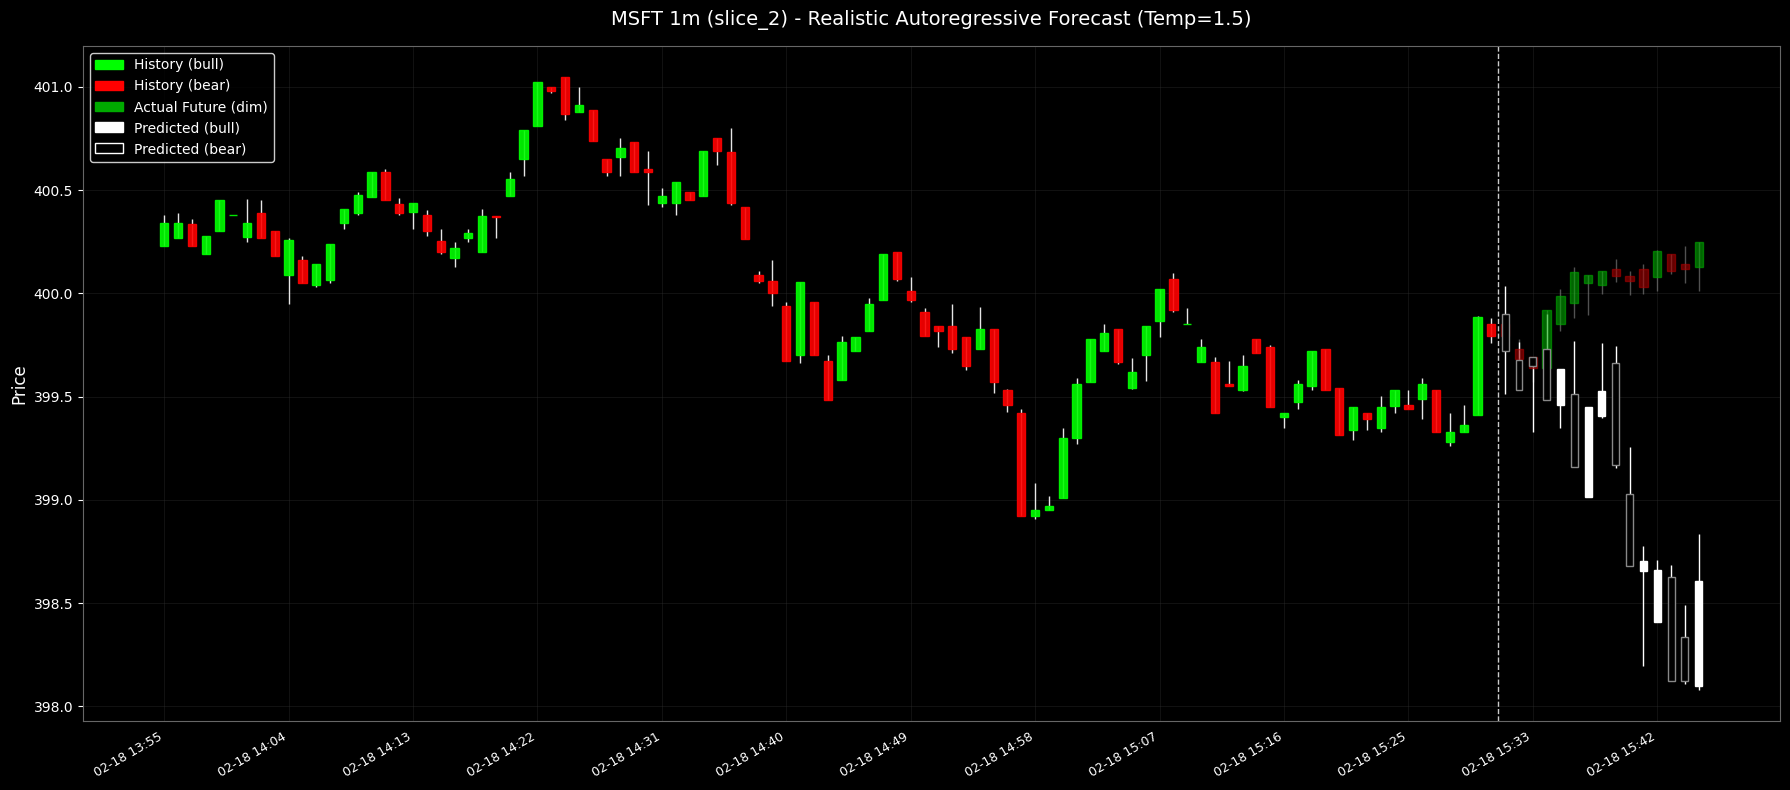


Final chart shows realistic candle generation with temperature 1.5
Increase SAMPLING_TEMPERATURE for more volatile predictions, decrease for smoother trends.


In [33]:
if fold_results:
    latest = fold_results[-1]
    
    fig, ax = plt.subplots(figsize=(18, 8), facecolor='black')
    ax.set_facecolor('black')
    
    def draw_candles(ax, ohlc, start_x, up_edge, up_face, down_edge, down_face, wick_color, width=0.6, alpha=1.0):
        vals = ohlc[OHLC_COLS].to_numpy()
        for i, (o, h, l, c) in enumerate(vals):
            x = start_x + i
            bull = c >= o
            ax.vlines(x, l, h, color=wick_color, linewidth=1.0, alpha=alpha, zorder=2)
            lower = min(o, c)
            height = max(abs(c - o), 1e-6)
            rect = Rectangle((x - width/2, lower), width, height,
                           facecolor=up_face if bull else down_face,
                           edgecolor=up_edge if bull else down_edge,
                           linewidth=1.0, alpha=alpha, zorder=3)
            ax.add_patch(rect)
    
    context_df = latest['context_df']
    actual_future_df = latest['actual_future_df']
    pred_future_df = latest['pred_future_df']
    
    # Draw history (green/red)
    draw_candles(ax, context_df, 0, '#00FF00', '#00FF00', '#FF0000', '#FF0000', '#FFFFFF', width=0.6, alpha=0.9)
    
    # Draw actual future (dimmed)
    draw_candles(ax, actual_future_df, len(context_df), '#00AA00', '#00AA00', '#AA0000', '#AA0000', '#888888', 
                 width=0.6, alpha=0.6)
    
    # Draw realistic prediction (bright white/black with glow effect)
    draw_candles(ax, pred_future_df, len(context_df), '#FFFFFF', '#FFFFFF', '#888888', '#000000', '#FFFFFF',
                 width=0.5, alpha=1.0)
    
    ax.axvline(len(context_df) - 0.5, color='white', linestyle='--', linewidth=1.0, alpha=0.8)
    
    # Labels
    n = len(context_df) + len(actual_future_df)
    step = max(1, n // 12)
    ticks = list(range(0, n, step))
    all_idx = context_df.index.append(actual_future_df.index)
    labels = [all_idx[i].strftime('%m-%d %H:%M') for i in ticks if i < len(all_idx)]
    
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=30, ha='right', color='white', fontsize=9)
    ax.tick_params(axis='y', colors='white')
    for sp in ax.spines.values():
        sp.set_color('#666666')
    ax.grid(color='#333333', linewidth=0.5, alpha=0.5)
    
    ax.set_title(f'MSFT 1m ({latest["fold"]}) - Realistic Autoregressive Forecast (Temp={SAMPLING_TEMPERATURE})', 
                 color='white', fontsize=14, pad=15)
    ax.set_ylabel('Price', color='white', fontsize=12)
    
    # Legend
    legend_elements = [
        Patch(facecolor='#00FF00', edgecolor='#00FF00', label='History (bull)'),
        Patch(facecolor='#FF0000', edgecolor='#FF0000', label='History (bear)'),
        Patch(facecolor='#00AA00', edgecolor='#00AA00', label='Actual Future (dim)'),
        Patch(facecolor='#FFFFFF', edgecolor='#FFFFFF', label='Predicted (bull)'),
        Patch(facecolor='#000000', edgecolor='#FFFFFF', label='Predicted (bear)'),
    ]
    ax.legend(handles=legend_elements, facecolor='black', edgecolor='white', labelcolor='white', 
             loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal chart shows realistic candle generation with temperature {SAMPLING_TEMPERATURE}")
    print("Increase SAMPLING_TEMPERATURE for more volatile predictions, decrease for smoother trends.")

## V8 Extension: Rolling Walk-Forward Backtest (Strictly Causal)
This section adds a full bar-by-bar rolling engine on top of the v7 training pipeline above.

Important:
- Model architecture is unchanged (`Seq2SeqAttnGRU` + `generate_realistic`).
- No checkpoint is required; the model is trained in this notebook first.
- Rolling predictions are strictly causal at anchor time `t` using only `[t-window, ..., t-1]`.

In [34]:
# V8 rolling configuration (frame generator mode)
from dataclasses import dataclass
from pathlib import Path
from typing import List, Dict, Optional, Tuple
from matplotlib.backends.backend_agg import FigureCanvasAgg  # non-interactive rendering

ROLLINGSTARTTIME = '09:30'
ROLLINGENDTIME = '16:00'
ROLLING_STEP = 1  # 1 = every minute

DEFAULT_ROLLING_TEMPERATURE = 1.5
USE_TEMPERATURE_SCHEDULE = True
TEMPERATURESCHEDULE = [
    ('09:30', '10:15', 1.25),
    ('10:15', '14:00', 1.45),
    ('14:00', '16:00', 1.60),
]

# Optional explicit date; if None, auto-selects a valid day.
ROLLING_BACKTEST_DATE = None  # e.g. '2025-02-13'

# Frame output config
FRAME_OUTPUT_DIR = Path(r'D:\APPS\Github\SDP-Technical')
FRAME_FILENAME_PATTERN = 'frame_{:04d}.png'  # frame_0000.png ...
FRAME_DPI = 180
FRAME_FIGSIZE = (18, 8)
FRAME_HISTORY_BARS = 220

print({
    'ROLLINGSTARTTIME': ROLLINGSTARTTIME,
    'ROLLINGENDTIME': ROLLINGENDTIME,
    'ROLLING_STEP': ROLLING_STEP,
    'DEFAULT_ROLLING_TEMPERATURE': DEFAULT_ROLLING_TEMPERATURE,
    'USE_TEMPERATURE_SCHEDULE': USE_TEMPERATURE_SCHEDULE,
    'ROLLING_BACKTEST_DATE': ROLLING_BACKTEST_DATE,
    'FRAME_OUTPUT_DIR': str(FRAME_OUTPUT_DIR),
    'FRAME_DPI': FRAME_DPI,
})


{'ROLLINGSTARTTIME': '09:30', 'ROLLINGENDTIME': '16:00', 'ROLLING_STEP': 1, 'DEFAULT_ROLLING_TEMPERATURE': 1.5, 'USE_TEMPERATURE_SCHEDULE': True, 'ROLLING_BACKTEST_DATE': None, 'FRAME_OUTPUT_DIR': 'D:\\APPS\\Github\\SDP-Technical', 'FRAME_DPI': 180}


In [35]:
# Train a v7 model for rolling backtest (no checkpoint needed)
def _intraday_positions_for_date(df: pd.DataFrame, date_str: str, start_time: str, end_time: str) -> np.ndarray:
    idx = df.index
    day_mask = (idx.strftime('%Y-%m-%d') == date_str)
    st = pd.Timestamp(start_time).time()
    et = pd.Timestamp(end_time).time()
    time_mask = np.array([(t >= st) and (t < et) for t in idx.time], dtype=bool)
    return np.where(day_mask & time_mask)[0]


def _select_backtest_date(df: pd.DataFrame, requested: Optional[str], window: int, horizon: int) -> str:
    if requested is not None:
        pos = _intraday_positions_for_date(df, requested, ROLLINGSTARTTIME, ROLLINGENDTIME)
        if len(pos) == 0:
            raise ValueError(f'No intraday bars for requested date: {requested}')
        if pos[0] < window:
            raise ValueError(f'Requested date {requested} does not have enough prior bars for window={window}')
        if pos[-1] + horizon >= len(df):
            raise ValueError(f'Requested date {requested} lacks future bars for horizon={horizon}')
        return requested

    # Auto-pick latest valid date excluding final date to ensure future bars for full 390 anchors.
    dates = sorted(pd.Index(df.index.strftime('%Y-%m-%d')).unique())
    if len(dates) < 2:
        raise RuntimeError('Need at least 2 trading dates for rolling backtest with full horizon labels.')

    for d in reversed(dates[:-1]):
        pos = _intraday_positions_for_date(df, d, ROLLINGSTARTTIME, ROLLINGENDTIME)
        if len(pos) < 390:
            continue
        if pos[0] < window:
            continue
        if pos[-1] + horizon >= len(df):
            continue
        return d

    raise RuntimeError('Could not auto-select a valid backtest date with full intraday coverage.')


def train_v7_model_for_rolling(
    price_df_full: pd.DataFrame,
    window: int,
    horizon: int,
    backtest_date: str,
) -> Tuple[nn.Module, pd.DataFrame, np.ndarray, np.ndarray, pd.DataFrame]:
    feat_all = build_feature_frame(price_df_full)
    target_all = build_target_frame(feat_all)

    all_dates = feat_all.index.strftime('%Y-%m-%d')
    train_day_mask = all_dates < backtest_date
    if train_day_mask.sum() < (window + horizon + 500):
        raise RuntimeError(
            f'Not enough pre-backtest bars before {backtest_date}: {train_day_mask.sum()} rows.'
        )

    input_raw = feat_all[BASE_FEATURE_COLS].to_numpy(np.float32)
    target_raw = target_all[TARGET_COLS].to_numpy(np.float32)
    row_imputed = feat_all['row_imputed'].to_numpy(np.int8).astype(bool)
    row_open_skip = feat_all['row_open_skip'].to_numpy(np.int8).astype(bool)
    prev_close = feat_all['prev_close'].to_numpy(np.float32)

    # Fit scaler using ONLY pre-backtest rows (causal-safe scaling).
    pre_idx = np.where(train_day_mask)[0]
    fit_end = int(pre_idx[-1]) + 1

    in_mean = input_raw[:fit_end].mean(axis=0)
    in_std = input_raw[:fit_end].std(axis=0)
    in_std = np.where(in_std < 1e-8, 1.0, in_std)
    input_scaled = ((input_raw - in_mean) / in_std).astype(np.float32)

    # v7 target setup (no target scaling)
    target_scaled = target_raw.copy()

    X_all, y_all_s, y_all_r, starts, prev_close_starts, drop_imp, drop_skip = make_multistep_windows(
        input_scaled=input_scaled,
        target_scaled=target_scaled,
        target_raw=target_raw,
        row_imputed=row_imputed,
        row_open_skip=row_open_skip,
        starts_prev_close=prev_close,
        window=window,
        horizon=horizon,
    )

    if len(X_all) == 0:
        raise RuntimeError('No windows available after filtering.')

    # Keep windows whose prediction horizon end is strictly before backtest date.
    end_idx = starts + horizon - 1
    end_dates = feat_all.index[end_idx].strftime('%Y-%m-%d')
    usable = end_dates < backtest_date

    X_all = X_all[usable]
    y_all_s = y_all_s[usable]
    y_all_r = y_all_r[usable]

    if len(X_all) < 1000:
        raise RuntimeError(f'Not enough usable windows before backtest date ({len(X_all)}).')

    split = int(len(X_all) * 0.85)
    X_train, y_train_s, y_train_r = X_all[:split], y_all_s[:split], y_all_r[:split]
    X_val, y_val_s, y_val_r = X_all[split:], y_all_s[split:], y_all_r[split:]

    train_loader = DataLoader(MultiStepDataset(X_train, y_train_s, y_train_r), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(MultiStepDataset(X_val, y_val_s, y_val_r), batch_size=BATCH_SIZE, shuffle=False)

    model = Seq2SeqAttnGRU(
        input_size=X_train.shape[-1],
        output_size=len(TARGET_COLS),
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT,
        horizon=horizon,
    ).to(DEVICE)

    print({
        'train_windows': len(X_train),
        'val_windows': len(X_val),
        'dropped_target_imputed': int(drop_imp),
        'dropped_target_open_skip': int(drop_skip),
        'backtest_date': backtest_date,
    })

    history_df = train_model(model, train_loader, val_loader, max_epochs=FINAL_MAX_EPOCHS, patience=FINAL_PATIENCE)
    return model, feat_all, in_mean.astype(np.float32), in_std.astype(np.float32), history_df


ROLLING_BACKTEST_DATE = _select_backtest_date(price_df, ROLLING_BACKTEST_DATE, DEFAULT_LOOKBACK, HORIZON)
print(f'Selected rolling backtest date: {ROLLING_BACKTEST_DATE}')

rolling_model, rolling_feat_df, rolling_in_mean, rolling_in_std, rolling_train_history = train_v7_model_for_rolling(
    price_df_full=price_df,
    window=DEFAULT_LOOKBACK,
    horizon=HORIZON,
    backtest_date=ROLLING_BACKTEST_DATE,
)

print('Rolling model trained and ready.')

Selected rolling backtest date: 2026-02-17
{'train_windows': 21874, 'val_windows': 3861, 'dropped_target_imputed': 2713, 'dropped_target_open_skip': 1556, 'backtest_date': '2026-02-17'}
Epoch 01 | tf=1.000 | train=0.950898 (nll=0.835632) | val=-4.920405 (nll=-4.970893) | lr=0.0005
Epoch 02 | tf=0.950 | train=-5.950434 (nll=-5.999749) | val=-6.962388 (nll=-7.012804) | lr=0.0005
Epoch 03 | tf=0.902 | train=-6.136982 (nll=-6.186185) | val=-5.991614 (nll=-6.040008) | lr=0.0005
Epoch 04 | tf=0.857 | train=-6.405616 (nll=-6.454991) | val=-4.540194 (nll=-4.590609) | lr=0.0005
Epoch 05 | tf=0.815 | train=-7.142017 (nll=-7.191347) | val=-8.030107 (nll=-8.080521) | lr=0.0005
Epoch 06 | tf=0.774 | train=-6.988215 (nll=-7.037501) | val=-6.819085 (nll=-6.869505) | lr=0.0005
Epoch 07 | tf=0.735 | train=-6.951150 (nll=-7.000454) | val=-7.282136 (nll=-7.332551) | lr=0.0005
Epoch 08 | tf=0.698 | train=-7.219659 (nll=-7.268899) | val=-6.923567 (nll=-6.971956) | lr=0.0005
Epoch 09 | tf=0.663 | train=-7.1

In [36]:
# Rolling log structure + strictly causal rolling engine
@dataclass
class RollingPredictionLog:
    anchortime: pd.Timestamp
    contextendprice: float
    predictedpath: pd.DataFrame
    actualpath: pd.DataFrame
    predictionhorizon: int
    temperature: float
    context_start_idx: int
    context_end_idx: int  # exclusive; equals anchor position

    step_mae: Optional[np.ndarray] = None
    directional_hit: Optional[bool] = None

    def __post_init__(self):
        assert len(self.predictedpath) == self.predictionhorizon
        assert len(self.actualpath) == self.predictionhorizon
        assert self.predictedpath.index[0] == self.anchortime, (
            f'Off-by-one: first prediction ts {self.predictedpath.index[0]} != anchor {self.anchortime}'
        )
        assert self.actualpath.index[0] == self.anchortime, (
            f'Off-by-one: first actual ts {self.actualpath.index[0]} != anchor {self.anchortime}'
        )

    def compute_metrics(self):
        p = self.predictedpath['Close'].to_numpy(np.float32)
        a = self.actualpath['Close'].to_numpy(np.float32)
        self.step_mae = np.abs(p - a)
        self.directional_hit = bool(np.sign(p[0] - self.contextendprice) == np.sign(a[0] - self.contextendprice))
        return self


class RollingBacktester:
    def __init__(
        self,
        model: nn.Module,
        pricedf: pd.DataFrame,
        featuredf: pd.DataFrame,
        input_mean: np.ndarray,
        input_std: np.ndarray,
        windowsize: int,
        horizon: int,
    ):
        self.model = model.to(DEVICE)
        self.model.eval()
        self.pricedf = pricedf.copy()
        self.featuredf = featuredf.copy()
        self.input_mean = input_mean.astype(np.float32)
        self.input_std = np.where(input_std.astype(np.float32) < 1e-8, 1.0, input_std.astype(np.float32))
        self.windowsize = int(windowsize)
        self.horizon = int(horizon)

        self.input_raw = self.featuredf[BASE_FEATURE_COLS].to_numpy(np.float32)
        self.input_scaled = ((self.input_raw - self.input_mean) / self.input_std).astype(np.float32)
        self.row_imputed = self.featuredf['row_imputed'].to_numpy(np.int8).astype(bool)

        self.ts_to_pos = {ts: i for i, ts in enumerate(self.featuredf.index)}
        self.day_anchor_positions: Optional[np.ndarray] = None
        self.selected_anchor_positions: Optional[np.ndarray] = None

    def _temperature_for_time(self, ts: pd.Timestamp) -> float:
        if not USE_TEMPERATURE_SCHEDULE:
            return float(DEFAULT_ROLLING_TEMPERATURE)
        t = ts.time()
        for st_s, en_s, temp in TEMPERATURESCHEDULE:
            st = pd.Timestamp(st_s).time()
            en = pd.Timestamp(en_s).time()
            if st <= t < en:
                return float(temp)
        return float(DEFAULT_ROLLING_TEMPERATURE)

    def _hist_vol(self, context_start: int, context_end: int) -> float:
        closes = self.pricedf['Close'].iloc[context_start:context_end].to_numpy(np.float32)
        if len(closes) < 2:
            return 0.001
        lr = np.log(closes[1:] / np.maximum(closes[:-1], 1e-8))
        return max(float(np.std(lr)), MIN_PREDICTED_VOL)

    @torch.no_grad()
    def _predict_path(self, context_start: int, context_end: int, temperature: float) -> np.ndarray:
        # Context is strictly [context_start, context_end), i.e. last visible bar is context_end-1.
        assert context_end - context_start == self.windowsize
        x_raw = self.input_scaled[context_start:context_end]
        imp_frac = float(self.row_imputed[context_start:context_end].mean())
        imp_col = np.full((self.windowsize, 1), imp_frac, dtype=np.float32)
        x_aug = np.concatenate([x_raw, imp_col], axis=1)
        x_tensor = torch.from_numpy(x_aug).unsqueeze(0).float().to(DEVICE)

        hist_vol = self._hist_vol(context_start, context_end)
        pred_ret = self.model.generate_realistic(x_tensor, temperature=temperature, historical_vol=hist_vol)[0]
        return pred_ret.detach().cpu().numpy()

    def runrollingbacktest(self, starttime: str, endtime: str, date: str, step: int = 1) -> Tuple[List[RollingPredictionLog], int]:
        idx = self.featuredf.index
        st = pd.Timestamp(starttime).time()
        en = pd.Timestamp(endtime).time()
        mask = (idx.strftime('%Y-%m-%d') == date) & np.array([(t >= st) and (t < en) for t in idx.time], dtype=bool)
        anchor_positions = np.where(mask)[0]

        if len(anchor_positions) == 0:
            raise RuntimeError(f'No anchors for date={date} {starttime}-{endtime}')

        selected = anchor_positions[::step]
        self.day_anchor_positions = anchor_positions
        self.selected_anchor_positions = selected

        logs: List[RollingPredictionLog] = []

        pbar = tqdm(total=len(selected), desc=f'Processing minute 0/{len(selected)}')
        for k, anchor_pos in enumerate(selected, start=1):
            context_end = int(anchor_pos)
            context_start = context_end - self.windowsize
            if context_start < 0:
                continue

            # position of this anchor inside same-day sequence
            day_idx = np.searchsorted(anchor_positions, anchor_pos)
            valid_steps = min(self.horizon, len(anchor_positions) - day_idx)
            if valid_steps <= 0:
                continue

            prediction_time = idx[context_end]
            context = self.featuredf.iloc[context_start:context_end]

            # CRITICAL strict-causality check requested by user
            assert context.index[-1] < prediction_time, (
                f'Causality violation: context last {context.index[-1]} is not before prediction {prediction_time}'
            )

            temp = self._temperature_for_time(prediction_time)
            pred_rets_full = self._predict_path(context_start, context_end, temp)
            pred_rets = pred_rets_full[:valid_steps]

            context_close = float(self.featuredf['prev_close'].iloc[context_end])
            pred_prices = returns_to_prices_seq(pred_rets, context_close)

            future_positions = anchor_positions[day_idx: day_idx + valid_steps]
            pred_index = idx[future_positions]
            pred_df = pd.DataFrame(pred_prices, index=pred_index, columns=OHLC_COLS)
            actual_df = self.pricedf[OHLC_COLS].iloc[future_positions].copy()

            log = RollingPredictionLog(
                anchortime=prediction_time,
                contextendprice=context_close,
                predictedpath=pred_df,
                actualpath=actual_df,
                predictionhorizon=valid_steps,
                temperature=temp,
                context_start_idx=context_start,
                context_end_idx=context_end,
            ).compute_metrics()
            logs.append(log)

            pbar.set_description(f'Processing minute {k}/{len(selected)}')
            pbar.update(1)

        pbar.close()

        expected_count = len(selected)
        return logs, expected_count


def runrollingbacktest(model, pricedf, windowsize, starttime, endtime):
    rb = RollingBacktester(
        model=model,
        pricedf=pricedf,
        featuredf=rolling_feat_df,
        input_mean=rolling_in_mean,
        input_std=rolling_in_std,
        windowsize=windowsize,
        horizon=HORIZON,
    )
    return rb.runrollingbacktest(starttime=starttime, endtime=endtime, date=ROLLING_BACKTEST_DATE, step=ROLLING_STEP), rb

In [38]:
# Run rolling backtest + required validation asserts
from tqdm import tqdm
(rolling_logs, expected_prediction_count), rolling_backtester = runrollingbacktest(
    model=rolling_model,
    pricedf=price_df,
    windowsize=DEFAULT_LOOKBACK,
    starttime=ROLLINGSTARTTIME,
    endtime=ROLLINGENDTIME,
)

if len(rolling_logs) == 0:
    raise RuntimeError('No rolling logs produced.')

# Required assert 1: first prediction timestamp equals anchor timestamp
assert rolling_logs[0].predictedpath.index[0] == rolling_logs[0].anchortime, (
    'first prediction first candle timestamp does not equal prediction anchor time'
)

# Required assert 2: no prediction uses future context
for log in rolling_logs:
    anchor_pos = rolling_backtester.ts_to_pos[log.anchortime]
    assert log.context_end_idx == anchor_pos, 'context_end_idx must equal anchor position'
    assert (log.context_end_idx - 1) < anchor_pos, 'context must strictly end at t-1'

# Required assert 3: prediction count equals expected minute anchors for this run
assert len(rolling_logs) == expected_prediction_count, (
    f'prediction count mismatch: {len(rolling_logs)} != {expected_prediction_count}'
)

print({
    'rolling_date': ROLLING_BACKTEST_DATE,
    'predictions_generated': len(rolling_logs),
    'expected_prediction_count': expected_prediction_count,
    'first_anchor': str(rolling_logs[0].anchortime),
    'first_prediction_first_ts': str(rolling_logs[0].predictedpath.index[0]),
    'last_horizon_steps': rolling_logs[-1].predictionhorizon,
})

Processing minute 390/390: 100%|█████████████████████████████████████████████████████| 390/390 [00:04<00:00, 80.49it/s]

{'rolling_date': '2026-02-17', 'predictions_generated': 390, 'expected_prediction_count': 390, 'first_anchor': '2026-02-17 09:30:00', 'first_prediction_first_ts': '2026-02-17 09:30:00', 'last_horizon_steps': np.int64(1)}


In [39]:
# Generate standalone rolling frames (no fan overlays)
def _draw_candles(
    ax,
    ohlc_df: pd.DataFrame,
    start_x: int,
    up_edge: str,
    up_face: str,
    down_edge: str,
    down_face: str,
    wick_color: str,
    width: float = 0.58,
    lw: float = 1.0,
    alpha: float = 1.0,
):
    vals = ohlc_df[OHLC_COLS].to_numpy(np.float32)
    for i, (o, h, l, c) in enumerate(vals):
        x = start_x + i
        bull = c >= o

        ax.vlines(x, l, h, color=wick_color, linewidth=lw, alpha=alpha, zorder=2)

        lower = min(o, c)
        height = max(abs(c - o), 1e-6)
        rect = Rectangle(
            (x - width / 2, lower),
            width,
            height,
            facecolor=up_face if bull else down_face,
            edgecolor=up_edge if bull else down_edge,
            linewidth=lw,
            alpha=alpha,
            zorder=3,
        )
        ax.add_patch(rect)


def _format_ts(ts: pd.Timestamp) -> str:
    return ts.strftime('%I:%M %p').lstrip('0')


def render_single_frame(
    log: RollingPredictionLog,
    frame_idx: int,
    total_frames: int,
    pricedf: pd.DataFrame,
    history_bars: int = FRAME_HISTORY_BARS,
) -> plt.Figure:
    anchor_pos = rolling_backtester.ts_to_pos[log.anchortime]
    h_start = max(0, anchor_pos - history_bars)
    history_df = pricedf.iloc[h_start:anchor_pos][OHLC_COLS].copy()  # up to t-1 only

    actual_df = log.actualpath.copy()       # t..t+h-1 (same-day valid only)
    pred_df = log.predictedpath.copy()      # predicted t..t+h-1

    fig, ax = plt.subplots(figsize=FRAME_FIGSIZE, facecolor='black')
    FigureCanvasAgg(fig)  # non-interactive backend_agg canvas
    ax.set_facecolor('black')

    # Historical context (bright)
    _draw_candles(ax, history_df, 0,
                  up_edge='#00FF00', up_face='#00FF00',
                  down_edge='#FF0000', down_face='#FF0000',
                  wick_color='#D0D0D0', width=0.60, lw=1.0, alpha=0.95)

    # Actual future first (dim, behind prediction) -- REQUIRED DRAW ORDER
    future_start_x = len(history_df)
    _draw_candles(ax, actual_df, future_start_x,
                  up_edge='#1D6F42', up_face='#1D6F42',
                  down_edge='#8E2F25', down_face='#8E2F25',
                  wick_color='#8E8E8E', width=0.58, lw=0.9, alpha=0.40)

    # Predicted future on top (white/black)
    _draw_candles(ax, pred_df, future_start_x,
                  up_edge='#FFFFFF', up_face='#FFFFFF',
                  down_edge='#FFFFFF', down_face='#000000',
                  wick_color='#F3F3F3', width=0.50, lw=1.2, alpha=1.0)

    # NOW divider
    now_x = len(history_df) - 0.5
    ax.axvline(now_x, color='white', linestyle='--', linewidth=1.0, alpha=0.85, zorder=4)
    ax.text(now_x + 0.8, ax.get_ylim()[1] if len(ax.get_ylim()) == 2 else 0.0, 'NOW', color='white', fontsize=9)

    # Axes ticks from history+future timeline
    full_idx = history_df.index.append(actual_df.index)
    n = len(full_idx)
    step = max(1, n // 10)
    ticks = list(range(0, n, step))
    if ticks[-1] != n - 1:
        ticks.append(n - 1)
    labels = [full_idx[i].strftime('%H:%M') for i in ticks]

    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=25, ha='right', color='white', fontsize=9)

    ax.tick_params(axis='y', colors='white')
    for sp in ax.spines.values():
        sp.set_color('#666666')

    ax.grid(color='#242424', linewidth=0.6, alpha=0.35)

    header = (
        f"{SYMBOL} 1m | Timestamp: {_format_ts(log.anchortime)} | "
        f"Frame {frame_idx + 1}/{total_frames} | Temp={log.temperature:.2f}"
    )
    ax.set_title(header, color='white', pad=12)
    ax.set_ylabel('Price', color='white')

    # Frame counter corner label
    ax.text(
        0.01, 0.99,
        f'Frame {frame_idx + 1}/{total_frames}',
        transform=ax.transAxes,
        va='top', ha='left', color='white', fontsize=10,
        bbox=dict(facecolor='black', edgecolor='#666666', alpha=0.8, boxstyle='round,pad=0.25'),
    )

    legend_elements = [
        Patch(facecolor='#00FF00', edgecolor='#00FF00', label='History (bull)'),
        Patch(facecolor='#FF0000', edgecolor='#FF0000', label='History (bear)'),
        Patch(facecolor='#1D6F42', edgecolor='#1D6F42', label='Actual Future (dim bull)'),
        Patch(facecolor='#8E2F25', edgecolor='#8E2F25', label='Actual Future (dim bear)'),
        Patch(facecolor='#FFFFFF', edgecolor='#FFFFFF', label='Predicted (bull)'),
        Patch(facecolor='#000000', edgecolor='#FFFFFF', label='Predicted (bear)'),
    ]
    leg = ax.legend(handles=legend_elements, facecolor='black', edgecolor='#666666', loc='upper left')
    for t in leg.get_texts():
        t.set_color('white')

    plt.tight_layout()
    return fig


def generate_rolling_frames(logs: List[RollingPredictionLog], pricedf: pd.DataFrame, output_dir: Path) -> List[Path]:
    output_dir.mkdir(parents=True, exist_ok=True)
    total = len(logs)
    saved_paths: List[Path] = []

    pbar = tqdm(total=total, desc=f'Saving frame 0/{total}')
    for i, log in enumerate(logs):
        fig = render_single_frame(
            log=log,
            frame_idx=i,
            total_frames=total,
            pricedf=pricedf,
            history_bars=FRAME_HISTORY_BARS,
        )

        out_path = output_dir / FRAME_FILENAME_PATTERN.format(i)
        fig.savefig(out_path, dpi=FRAME_DPI, facecolor='black', bbox_inches='tight')
        saved_paths.append(out_path)

        # Required cleanup for memory safety
        plt.close('all')

        pbar.set_description(f'Saving frame {i + 1}/{total}')
        pbar.update(1)

    pbar.close()
    return saved_paths


saved_frame_paths = generate_rolling_frames(rolling_logs, price_df, FRAME_OUTPUT_DIR)

print({
    'frames_dir': str(FRAME_OUTPUT_DIR.resolve()),
    'frames_saved': len(saved_frame_paths),
    'first_frame': saved_frame_paths[0].name if saved_frame_paths else None,
    'last_frame': saved_frame_paths[-1].name if saved_frame_paths else None,
})

# Rolling metrics summary
hit_rate = float(np.mean([lg.directional_hit for lg in rolling_logs if lg.directional_hit is not None]))

def _mae_at(step_1_based: int) -> float:
    vals = [float(lg.step_mae[step_1_based - 1]) for lg in rolling_logs if lg.step_mae is not None and len(lg.step_mae) >= step_1_based]
    return float(np.mean(vals)) if vals else float('nan')

x = np.arange(HORIZON, dtype=np.float32)
p_slopes, a_slopes = [], []
for lg in rolling_logs:
    p = lg.predictedpath['Close'].to_numpy(np.float32)
    a = lg.actualpath['Close'].to_numpy(np.float32)
    if len(p) == HORIZON and len(a) == HORIZON:
        p_slopes.append(np.polyfit(x, p, 1)[0])
        a_slopes.append(np.polyfit(x, a, 1)[0])
trend_corr = float(np.corrcoef(p_slopes, a_slopes)[0, 1]) if len(p_slopes) > 1 else float('nan')

metrics_table = pd.DataFrame([
    ('Directional hit rate (t+1)', f'{hit_rate:.2%}'),
    ('Path MAE @ step 1', f'${_mae_at(1):.4f}'),
    ('Path MAE @ step 5', f'${_mae_at(5):.4f}'),
    ('Path MAE @ step 10', f'${_mae_at(10):.4f}'),
    ('Path MAE @ step 15', f'${_mae_at(15):.4f}'),
    ('Trend correlation (15-bar slope)', f'{trend_corr:.4f}'),
], columns=['Metric', 'Value'])

display(metrics_table)

Saving frame 390/390: 100%|██████████████████████████████████████████████████████████| 390/390 [04:15<00:00,  1.53it/s]

{'frames_dir': 'D:\\APPS\\Github\\SDP-Technical', 'frames_saved': 390, 'first_frame': 'frame_0000.png', 'last_frame': 'frame_0389.png'}


,Metric,Value
0,Directional hit rate (t+1),51.79%
1,Path MAE @ step 1,$0.3056
2,Path MAE @ step 5,$0.6574
3,Path MAE @ step 10,$1.0586
4,Path MAE @ step 15,$1.3321
5,Trend correlation (15-bar slope),-0.0658


### Validation checklist status
- Strict causality per frame (`assert context.index[-1] < prediction_time`): **asserted**
- First predicted candle timestamp equals anchor timestamp: **asserted**
- Prediction count equals expected minute anchors: **asserted**
- No fan overlays used: **replaced by standalone per-frame PNG rendering**
- Frames saved sequentially to `frames/frame_0000.png ...`: **implemented**